## **Churn Prediction**

- Preprocessing Data
- Feature Selection & Baseline Model Building
- Results


### I. Preprocessing Data

In [2]:
# importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
#Reading data set
df = pd.read_csv('churn_prediction.csv')

In [4]:
# imputing missing values
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [5]:
#missing value treatment
# 1. 'gender' Column
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [6]:
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

In [7]:
# 2. 'dependents' Column
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [9]:
# 3. 'occupation' column
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [10]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

In [11]:
# 4. 'city' column
df['city'] = df['city'].fillna(1020)

In [12]:
# 5. 'days_since_last_transaction' column
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

In [14]:
# Scaling data and conversion to continous variables
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

In [15]:
#importing necessary function
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve

In [16]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [17]:
df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [18]:
y_all = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

### II. Feature Selection & Baseline Model Building

In [19]:
# creating baseline columns
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']
df_baseline = df[baseline_cols]

In [20]:
# Splitting the data into Train and Test set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [21]:
# Applying Logistic Regressor Model
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

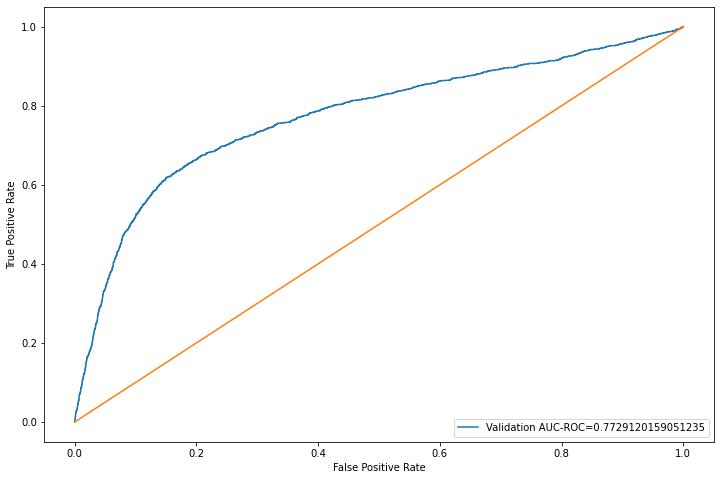

In [22]:
# Evaluation metrics 'AUC-ROC curves' & 'confusion metrix'
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [23]:
# Confusion Matrix
pred_val = model.predict(xtest)

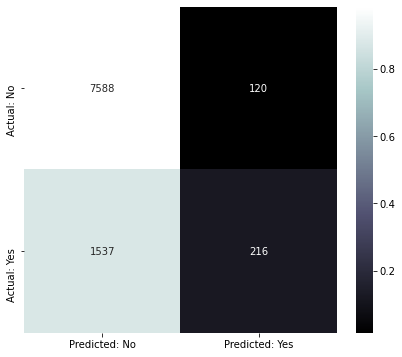

In [24]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [25]:
# Recall Score
recall_score(ytest,pred_val)

0.12321734169994296

In [26]:
# Implementing Cross Validation
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y_all.loc[df_index],y_all.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [27]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7658154352070702, Recall Score: 0.1036, Precision Score: 0.5798 

2 of kfold 5
ROC AUC Score: 0.7798544856643717, Recall Score: 0.1255, Precision Score: 0.6875 

3 of kfold 5
ROC AUC Score: 0.7542290512715935, Recall Score: 0.1198, Precision Score: 0.6300 

4 of kfold 5
ROC AUC Score: 0.7633279253884511, Recall Score: 0.1331, Precision Score: 0.6731 

5 of kfold 5
ROC AUC Score: 0.7638432973278777, Recall Score: 0.1169, Precision Score: 0.5829 


In [28]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.740799917788511, Recall Score: 0.1283, Precision Score: 0.5192 

2 of kfold 5
ROC AUC Score: 0.7687088685643819, Recall Score: 0.1987, Precision Score: 0.7037 

3 of kfold 5
ROC AUC Score: 0.7315088988514216, Recall Score: 0.1245, Precision Score: 0.5796 

4 of kfold 5
ROC AUC Score: 0.7471415050587445, Recall Score: 0.1445, Precision Score: 0.6878 

5 of kfold 5
ROC AUC Score: 0.7614742721065166, Recall Score: 0.1625, Precision Score: 0.6000 


In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rf_all_features = cv_score(RandomForestClassifier(n_estimators=100, max_depth=8))


1 of kfold 5
ROC AUC Score: 0.8178805878121467, Recall Score: 0.3413, Precision Score: 0.7194 

2 of kfold 5
ROC AUC Score: 0.8425462953447744, Recall Score: 0.3489, Precision Score: 0.7759 

3 of kfold 5
ROC AUC Score: 0.8350389396700303, Recall Score: 0.3432, Precision Score: 0.7505 

4 of kfold 5
ROC AUC Score: 0.8280072065730788, Recall Score: 0.3413, Precision Score: 0.7464 

5 of kfold 5
ROC AUC Score: 0.8225738048798137, Recall Score: 0.3441, Precision Score: 0.7373 


### III. Results

In [33]:
# Visualizing cross validation score for-
  # Baseline Model
  # Model based on all features
  # Model based on top 10 features obtained from RFE
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'random_forest': rf_all_features})

<AxesSubplot:>

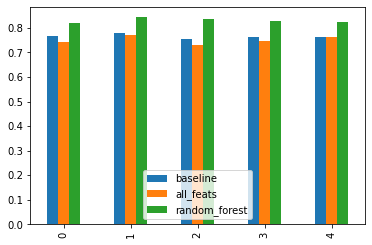

In [34]:
results_df.plot(y=["baseline", "all_feats", "random_forest"], kind="bar")